# Capital Asset Pricing Model (CAPM) with Python. 

This notebook is devoted to exploring some aspects of the Capital Asset Pricing Model (CAPM) using Python. According to CAPM, the expected return of a particular investment $E[r_{a}]$ is given the following equation:
$$
E[r_{a}] = r_{f} + \beta_{a}(E[r_{m}]-r_{f})\,,
$$
where $r_{f}$ is the a risk free return (like goverment bond returns), $E[r_{m}]$ is the expected return from the market, usually measured by the return on some index like S&P 500, and $\beta_{a}$ measures the volatility of the investement with respect to the market, and is formally given by:
$$
\beta_{a} = \frac{\text{Cov}(r_{a},r_{m})}{\text{Var}(r_{m})}\,.
$$
Thus, the model assumes a linear relationship between $E[r_{a}]$ and the quantity $(E[r_{m}]-r_{f})$, also called as the market premium, which is mediated by the coefficient $\beta_{a}$. If we would like to measure all the returns in the model with respect to the risk free rate $r_{f}$ and thus construct a linear regression between the quantities $(E[r_{a}]-r_{f})$ and the market premium $(E[r_{a}]-r_{f})$, one must the pose this relationship as:
$$
(E[r_{a}]-r_{f}) = \alpha + \beta_{a}(E[r_{m}]-r_{f})\,.
$$
In this manner, $\alpha$ meassures the difference between the expected return $E[r_{a}]$ as measured in real life, and the expected return of our investment as given by the CAPM:
$$
\alpha = E[r_{a}] - \left( r_{f} +\beta_{a}(E[r_{m}]-r_{f})\right)\,.
$$
Let us explore this using Python.

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf 
yf.pdr_override() 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

We will use ^GSPC to compute $E[r_{m}]$ and set $r_f = 0$, for simplicity. Let us then apply the CAPM to apple stocks. To capture less noise in our construction, we will focus on monthly returns. 

In [2]:
stock_a =['AAPL']
stock_m = ['^GSPC']

start = pd.to_datetime('2015-01-01') 
end = pd.to_datetime('2018-01-01')

data_a = pdr.get_data_yahoo(stock_a, start=start, end=end)['Adj Close']
data_m = pdr.get_data_yahoo(stock_m, start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [3]:
data_a.head()

Date
2015-01-02    101.14
2015-01-05     98.29
2015-01-06     98.30
2015-01-07     99.68
2015-01-08    103.51
Name: Adj Close, dtype: float64

We focus now on monthly returns:

In [4]:
M_stock_a = data_a.resample('M').last()
M_stock_m = data_m.resample('M').last()

data = pd.DataFrame({'Inv_Close':M_stock_a, 'Markt_Close': M_stock_m})
data.head()

,Inv_Close,Markt_Close
Date,,
2015-01-31,108.38,1994.99
2015-02-28,119.30,2104.50
2015-03-31,115.56,2067.89
2015-04-30,116.23,2085.51
2015-05-31,121.50,2107.39


And now we compute the log returns:

In [5]:
data[['Inv_Ret','Markt_Ret']] = np.log(data[['Inv_Close','Markt_Close']]/data[['Inv_Close','Markt_Close']].shift(1))
data.dropna(inplace=True)
data.head()

,Inv_Close,Markt_Close,Inv_Ret,Markt_Ret
Date,,,,
2015-02-28,119.30,2104.50,0.095998,0.053439
2015-03-31,115.56,2067.89,-0.031851,-0.017549
2015-04-30,116.23,2085.51,0.005781,0.008485
2015-05-31,121.50,2107.39,0.044343,0.010437
2015-06-30,116.98,2063.11,-0.037911,-0.021236


The scatter plot of returns looks like this:

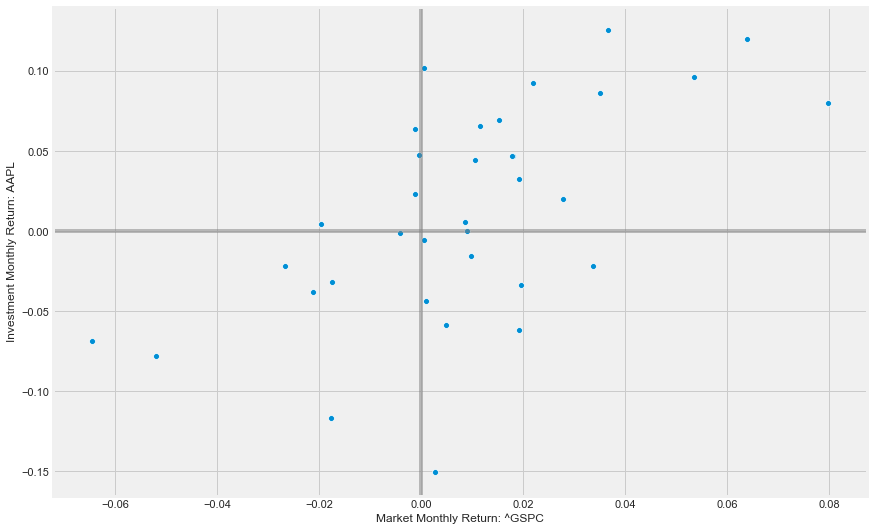

In [6]:
plt.figure(figsize = (13,9))

plt.axvline(0, color='grey', alpha = 0.5)
plt.axhline(0, color='grey', alpha = 0.5)
sns.scatterplot(y = 'Inv_Ret', x = 'Markt_Ret', data = data)
plt.xlabel('Market Monthly Return: {}'.format(stock_m[0]))
plt.ylabel('Investment Monthly Return: {}'.format(stock_a[0]))
plt.show()

We now compute $\beta$ according to the CAPM formula:

In [9]:
beta_form = (data[['Inv_Ret','Markt_Ret']].cov()/data['Markt_Ret'].var()).iloc[0].iloc[1]
print('Beta from CAPM formula: ',beta_form.round(4))

Beta from CAPM formula:  1.4376


Now, with our returns data, we make a linear regression and compute $\alpha$ and $\beta$:

In [10]:
beta_reg, alpha = np.polyfit(x = data['Markt_Ret'] , y = data['Inv_Ret'] ,deg = 1)
print('Beta from Linear Regression: ',beta_reg.round(4))
print('Alpha: ', alpha.round(3))

Beta from Linear Regression:  1.4376
Alpha:  0.0


Finally, we plot our returns scatter plot along with the CAPM line:

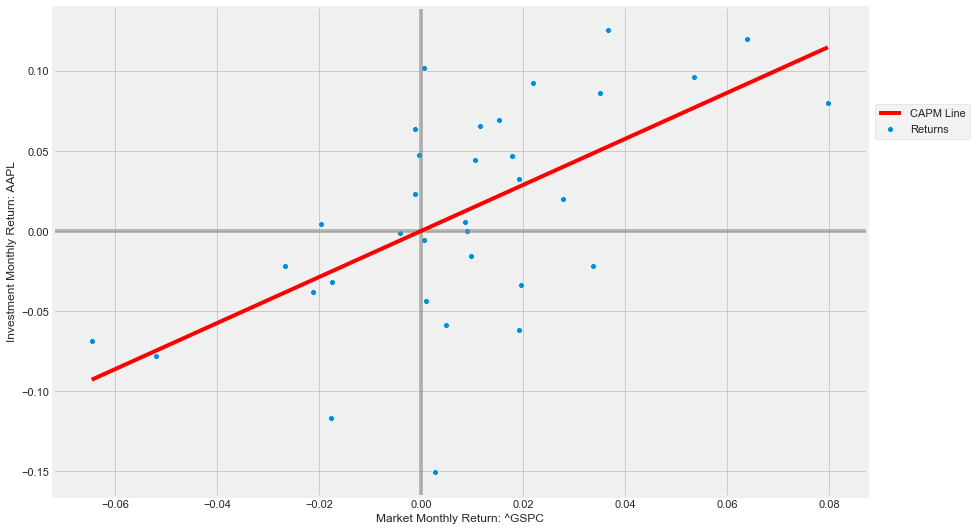

In [20]:
plt.figure(figsize = (13,9))

plt.axvline(0, color='grey', alpha = 0.5)
plt.axhline(0, color='grey', alpha = 0.5)

sns.scatterplot(y = 'Inv_Ret', x = 'Markt_Ret', data = data, label = 'Returns')
sns.lineplot(x = data['Markt_Ret'], y = alpha + data['Markt_Ret']*beta_reg, color = 'red', label = 'CAPM Line')



plt.xlabel('Market Monthly Return: {}'.format(stock_m[0]))
plt.ylabel('Investment Monthly Return: {}'.format(stock_a[0]))

plt.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0.)

plt.show()

# ==========================================

We now define a single function that gives us $\alpha$, $\beta$ and the corresponding plot. 

In [24]:
def CAPM(stock_a,stock_m,start, end):
    
    data_a = pdr.get_data_yahoo(stock_a, start=start, end=end)['Adj Close']
    data_m = pdr.get_data_yahoo(stock_m, start=start, end=end)['Adj Close']
    
    M_stock_a = data_a.resample('M').last()
    M_stock_m = data_m.resample('M').last()
    
    data = pd.DataFrame({'Inv_Close':M_stock_a, 'Markt_Close': M_stock_m})
    data[['Inv_Ret','Markt_Ret']] = np.log(data[['Inv_Close','Markt_Close']]/data[['Inv_Close','Markt_Close']].shift(1))
    data.dropna(inplace=True)
    
    beta_form = (data[['Inv_Ret','Markt_Ret']].cov()/data['Markt_Ret'].var()).iloc[0].iloc[1]
    beta_reg, alpha = np.polyfit(x = data['Markt_Ret'] , y = data['Inv_Ret'] ,deg = 1)
   

 
    print('\n')
    print(20*'==')
    print('Beta from formula: ',beta_form.round(4))
    print('Beta from Linear Regression: ',beta_reg.round(4))
    print('Alpha: ', alpha.round(3))
    print(20*'==')
    
    plt.figure(figsize = (13,9))
    
    plt.axvline(0, color='grey', alpha = 0.5)
    plt.axhline(0, color='grey', alpha = 0.5)

    sns.scatterplot(y = 'Inv_Ret', x = 'Markt_Ret', data = data, label = 'Returns')
    sns.lineplot(x = data['Markt_Ret'], y = alpha + data['Markt_Ret']*beta_reg, color = 'red', label = 'CAPM Line')

    plt.xlabel('Market Monthly Return: {}'.format(stock_m[0]))
    plt.ylabel('Investment Monthly Return: {}'.format(stock_a[0]))
    plt.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0.)

    plt.show()
    
    

We try with Apple:

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


Beta from formula:  1.395
Beta from Linear Regression:  1.395
Alpha:  0.004


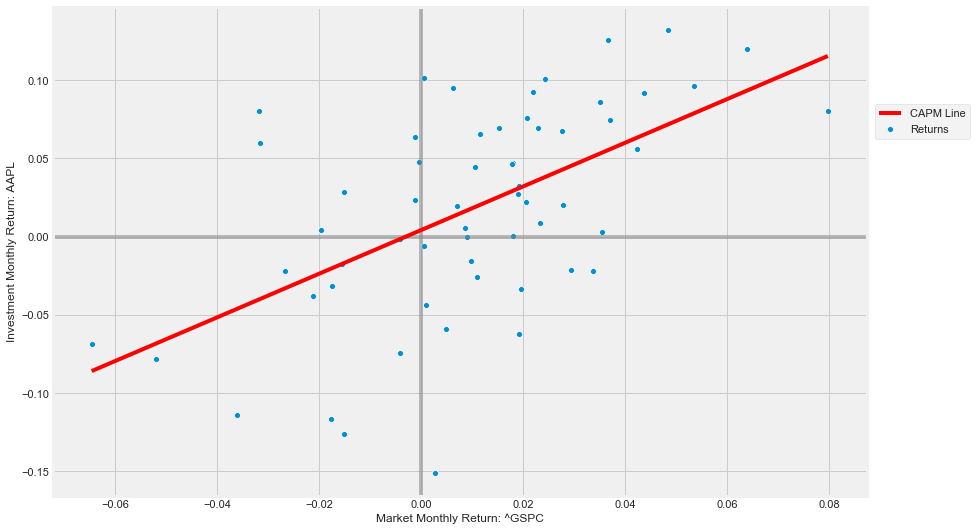

In [25]:
stock_a =['AAPL']
stock_m = ['^GSPC']

start = pd.to_datetime('2013-01-01') 
end = pd.to_datetime('2018-01-01')

CAPM(stock_a,stock_m,start, end)

We try with General Electric:

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


Beta from formula:  1.0227
Beta from Linear Regression:  1.0227
Alpha:  -0.011


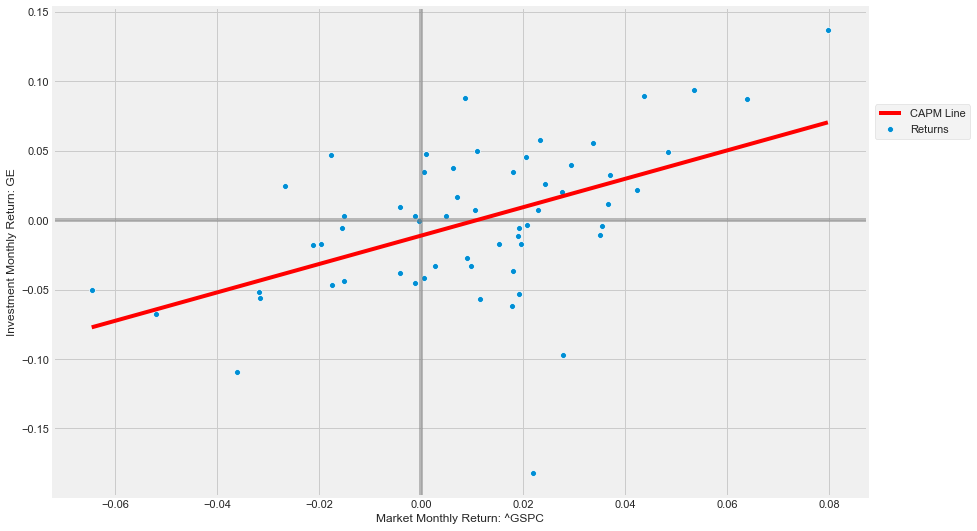

In [26]:
stock_a =['GE']
stock_m = ['^GSPC']

start = pd.to_datetime('2013-01-01') 
end = pd.to_datetime('2018-01-01')

CAPM(stock_a,stock_m,start, end)

We try with Advanced Micro Devices:

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


Beta from formula:  2.3585
Beta from Linear Regression:  2.3585
Alpha:  0.0


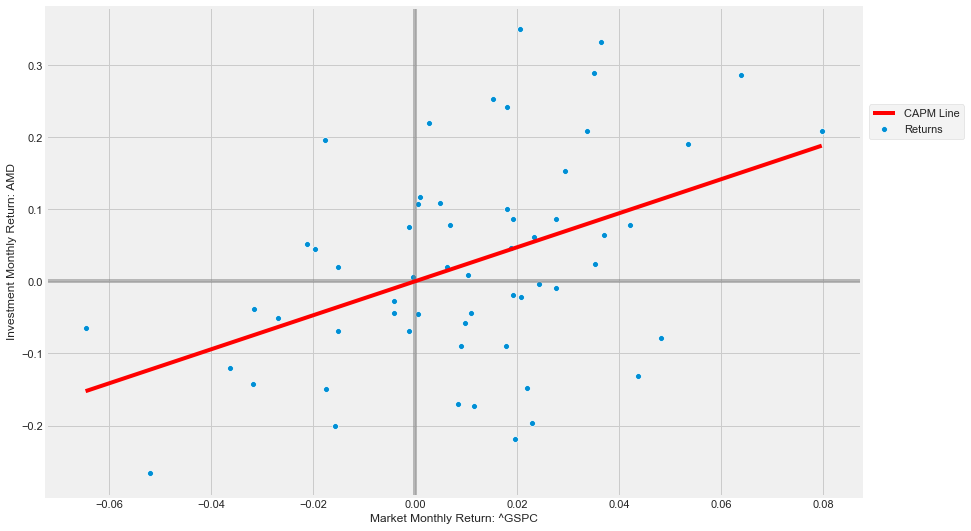

In [27]:
stock_a =['AMD']
stock_m = ['^GSPC']

start = pd.to_datetime('2013-01-01') 
end = pd.to_datetime('2018-01-01')

CAPM(stock_a,stock_m,start, end)

# ======================================================

Just for completeness, we can construct a similar function, now taking into consideration daily instead of monthly returns. 

In [28]:
def CAPM_daily(stock_a,stock_m,start, end):
    
    data_a = pdr.get_data_yahoo(stock_a, start=start, end=end)['Adj Close']
    data_m = pdr.get_data_yahoo(stock_m, start=start, end=end)['Adj Close']
    
    #M_stock_a = data_a.resample('M').last()
    #M_stock_m = data_m.resample('M').last()
    
    data = pd.DataFrame({'Inv_Close':data_a, 'Markt_Close': data_m})
    data[['Inv_Ret','Markt_Ret']] = np.log(data[['Inv_Close','Markt_Close']]/data[['Inv_Close','Markt_Close']].shift(1))
    data.dropna(inplace=True)
    
    beta_form = (data[['Inv_Ret','Markt_Ret']].cov()/data['Markt_Ret'].var()).iloc[0].iloc[1]
    beta_reg, alpha = np.polyfit(x = data['Markt_Ret'] , y = data['Inv_Ret'] ,deg = 1)
   

 
    print('\n')
    print(20*'==')
    print('Beta from formula: ',beta_form.round(4))
    print('Beta from Linear Regression: ',beta_reg.round(4))
    print('Alpha: ', alpha.round(3))
    print(20*'==')
    
    plt.figure(figsize = (13,9))
    
    plt.axvline(0, color='grey', alpha = 0.5)
    plt.axhline(0, color='grey', alpha = 0.5)

    sns.scatterplot(y = 'Inv_Ret', x = 'Markt_Ret', data = data, label = 'Returns')
    sns.lineplot(x = data['Markt_Ret'], y = alpha + data['Markt_Ret']*beta_reg, color = 'red', label = 'CAPM Line')

    plt.xlabel('Market Monthly Return: {}'.format(stock_m[0]))
    plt.ylabel('Investment Monthly Return: {}'.format(stock_a[0]))
    plt.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0.)

    plt.show()

We try again with Apple:

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


Beta from formula:  0.9772
Beta from Linear Regression:  0.9772
Alpha:  0.0


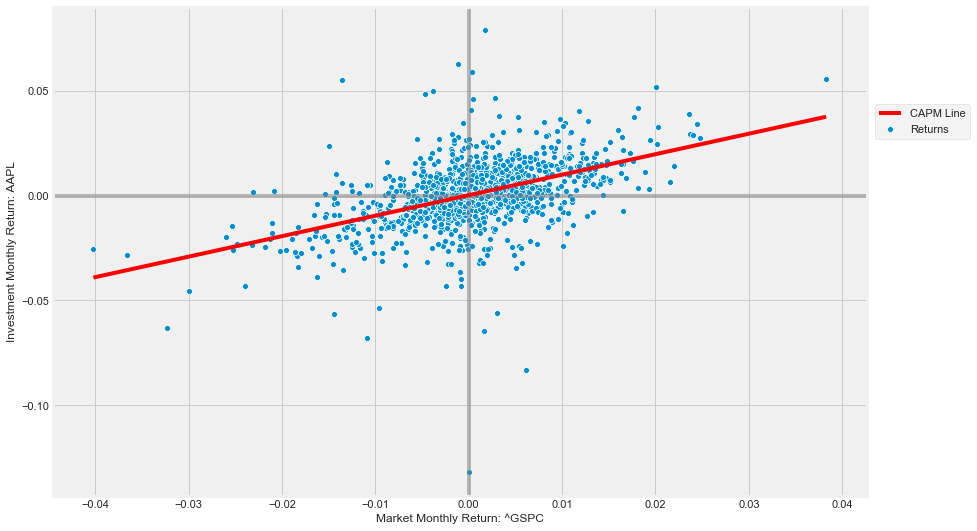

In [29]:
stock_a =['AAPL']
stock_m = ['^GSPC']

start = pd.to_datetime('2013-01-01') 
end = pd.to_datetime('2018-01-01')

CAPM_daily(stock_a,stock_m,start, end)

From this, we do notice a quantitative change in the estimation of Beta.